In [1]:
import altair as alt
import pandas as pd

In [3]:
# proper mapping (source's mapping is incomplete) from 
# http://www.grg.org/SC/SCListsTables.html
race_map = {'W':'White', 'B':'Black', 'H':'Hispanic', 'EA':'East Asian', 'O': 'Oriental', 'M':'Multiracial'}

# manually-cleaned source data from
# http://www.grg.org/Adams/C.HTM
dtype={'Age_Years':int, 'Age_Days':int, 'Reign_Years':int, 'Reign_Days':int, 'Reign_Length':float, 'Reign_Ascension_Age_Years':int, 'Reign_Ascension_Age_Days':int}
df = pd.read_csv('data.tsv', sep='\t', parse_dates=['Born', 'Died'], dtype=dtype)

# compute useful fields
df['Race_Text'] = df.Race.apply(lambda x: race_map[x])
df['Reign_Start'] = df.Born + df.Reign_Ascension_Age_Years.apply(lambda x: pd.Timedelta(x, unit='Y')) + df.Reign_Ascension_Age_Days.apply(lambda x: pd.Timedelta(x, unit='D'))
df['Reign_Start'] = pd.to_datetime(df['Reign_Start'].dt.date)

# update dates and ages for current record holder (#65 Kane Tanaka)
df.loc[64, 'Died'] = pd.to_datetime('2018-07-01')
df.loc[64, 'Age_Years'] = (df.loc[64, 'Died'] - df.loc[64, 'Born']).days // 365
df.loc[64, 'Age_Days'] = (df.loc[64, 'Died'] - df.loc[64, 'Born']).days % 365
df.loc[64, 'Reign_Days'] = (df.loc[64, 'Died'] - df.loc[64, 'Reign_Start']).days
df.loc[64, 'Reign_Years'] = (df.loc[64, 'Died'] - df.loc[64, 'Reign_Start']).days // 365
df.loc[64, 'Reign_Length'] = (df.loc[64, 'Died'] - df.loc[64, 'Reign_Start']).days / 365

# compute useful fields
df['Reign_Start_Age'] = df.Reign_Ascension_Age_Years + df.Reign_Ascension_Age_Days/365
df['Reign_End_Age'] = df.Age_Years + df.Age_Days/365

df = df[['#','Birthplace','Deathplace','Name','Born','Died','Sex','Race_Text','Reign_Start','Reign_Start_Age','Reign_End_Age']]
df.head()

,#,Birthplace,Deathplace,Name,Born,Died,Sex,Race_Text,Reign_Start,Reign_Start_Age,Reign_End_Age
0,1,England (UK),U.S. (NE),Betsy Baker,1842-08-20,1955-10-24,F,White,1954-08-20,112.000000,113.178082
1,2,England (UK),U.S. (CA),Jennie Howell,1845-02-11,1956-12-16,F,White,1955-10-24,110.698630,111.846575
2,3,Denmark,U.S. (NE),Anne Marie Carstenson,1849-01-24,1958-03-30,F,White,1956-12-16,107.895890,109.178082
3,4,U.S. (IN),U.S. (IN),Nancy Ryan,1849-09-05,1958-10-17,F,White,1958-03-30,108.564384,109.115068
4,5,Netherlands,Netherlands,Christina Karnebeek-Backs,1849-10-02,1959-10-07,F,White,1958-10-17,109.041096,110.013699


In [4]:
df_reign = pd.DataFrame()#columns=["name", "date", "age"])

for index, row in df.iterrows():
    # create a record for every month so that tooltips work across the whole line
    for date in pd.date_range(start=row['Reign_Start'], end=row['Died'], freq='M'):
        df_reign = df_reign.append({
            "name": row['Name'],
            "date": date,
            "age": row['Reign_Start_Age'] + (date - row['Reign_Start']).days/365,
            'birthplace': row['Birthplace'],
            'deathplace': row['Deathplace'],
            'race': row['Race_Text'],
            'sex': row['Sex'],
            'reign_start': row['Reign_Start'],
            'reign_end': row['Died'],
            }, ignore_index=True)

df_reign.head()

,age,birthplace,date,deathplace,name,race,reign_end,reign_start,sex
0,112.030137,England (UK),1954-08-31,U.S. (NE),Betsy Baker,White,1955-10-24,1954-08-20,F
1,112.112329,England (UK),1954-09-30,U.S. (NE),Betsy Baker,White,1955-10-24,1954-08-20,F
2,112.197260,England (UK),1954-10-31,U.S. (NE),Betsy Baker,White,1955-10-24,1954-08-20,F
3,112.279452,England (UK),1954-11-30,U.S. (NE),Betsy Baker,White,1955-10-24,1954-08-20,F
4,112.364384,England (UK),1954-12-31,U.S. (NE),Betsy Baker,White,1955-10-24,1954-08-20,F


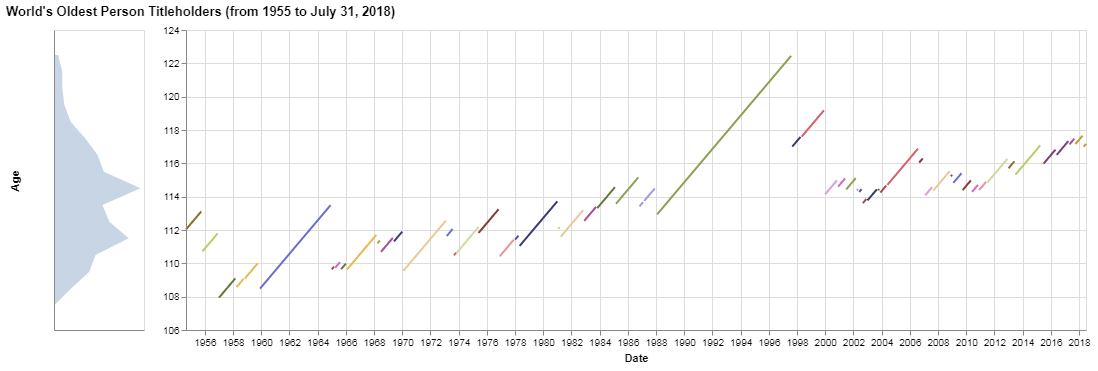

In [5]:
brush = alt.selection(type='interval')

# can't display dates because of bug in vega-lite2
# https://github.com/altair-viz/altair/issues/1270
tooltip = [ 
    alt.Tooltip('name', title='Name'),
    alt.Tooltip('sex', title='Sex'),
    alt.Tooltip('race', title='Race'),
    alt.Tooltip('birthplace', title='Birthplace'),
    alt.Tooltip('deathplace', title='Deathplace'),
]

# this invisible layer is for larger tooltips
points = alt.Chart().mark_circle(size=60).encode(
    x='date',
    y='age',
    opacity=alt.value(0),
    tooltip=tooltip
)

lines = alt.Chart().mark_line().encode(
    x=alt.X('date', timeUnit='yearmonthdate', axis=alt.Axis(title='Date', format='%Y')),
    y=alt.Y('age', scale=alt.Scale(zero=False), axis=alt.Axis(title='')),
    color=alt.condition(brush, alt.Color('name:O', legend=None, scale=alt.Scale(scheme='category20b')), alt.value('grey')),
    tooltip=tooltip
).properties(
    selection=brush,
    width=900,
    height=300
)

bar = alt.Chart().mark_area(opacity=0.3).encode(
    x=alt.X('count()', axis=alt.Axis(title='', labels=False, ticks=False, grid=False)),
    y=alt.Y('age', bin=alt.Bin(maxbins=20), axis=alt.Axis(title='Age', labels=False, ticks=False, grid=False), scale=alt.Scale(domain=(106, 124))),
).properties(
    width=90,
).transform_filter(brush)

chart = (bar | points + lines).properties(
    title="World's Oldest Person Titleholders (from 1955 to July 31, 2018)",
    spacing=10,
    data=df_reign
)

chart

In [6]:
chart.save('chart.html')